In [71]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 39.4 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install pyshp

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List
from copy import deepcopy

from PIL import Image
from IPython.display import display

import numpy as np
import cv2
import matplotlib.pyplot as plt

import shapefile
import utm

import sklearn


We will use python package `pyshp` to load shape file and handle precise connected components, instead of recomputed them from the mask pixels

In [3]:
sf = shapefile.Reader("Separation_Objets/cars")
shapes = sf.shapes()

In [4]:
# FACTOR = 10

# def get_lower_long_coordinate(shapes: List[shapefile.Shape]):
#     '''Get the lower longitude from list of (long, lat) bounding boxes
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             lower_long (str): west most longitude
#     '''
#     lower_long = shapes[0].bbox[0]
#     for shape in shapes[1:]:
#         if shape.bbox[0] < lower_long:
#             lower_long = shape.bbox[0]
#     return lower_long

# def get_greater_long_coordinate(shapes: List[shapefile.Shape]):
#     '''Get the greater longitude from list of (long, lat) bounding box
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             greater_long (str): east most longitude
#     '''
#     greater_long = shapes[0].bbox[2]
#     for shape in shapes[1:]:
#         if shape.bbox[2] > greater_long:
#             greater_long = shape.bbox[2]
#     return greater_long

# def get_lower_lat_coordinate(shapes: List[shapefile.Shape]):
#     '''Get the lower latitude from list of (long, lat) bounding boxes
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             lower_lat (str): south most longitude
#     '''
#     lower_lat = shapes[1:][0].bbox[1]
#     for shape in shapes:
#         if shape.bbox[1] < lower_lat:
#             lower_lat = shape.bbox[1]
#     return lower_lat

# def get_greater_lat_coordinate(shapes: List[shapefile.Shape]):
#     '''Get the greater latitude from list of (long, lat) bounding boxes
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             greater_lat (str): north most longitude
#     '''
#     greater_lat = shapes[0].bbox[3]
#     for shape in shapes[1:]:
#         if shape.bbox[3] > greater_lat:
#             greater_lat = shape.bbox[3]
#     return greater_lat

# def get_bounding_box_zone(shapes: List[shapefile.Shape]):
#     '''Get the long,lat bbox coordinates of the bbox of the whole zone represented by shapes
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             zone_shap (List): list of (long, lat) tuples for the bounding box of the zone from East/North in clockwise order
#     '''
#     lower_long = get_lower_long_coordinate(shapes)
#     greater_long = get_greater_long_coordinate(shapes)
#     lower_lat = get_lower_lat_coordinate(shapes)
#     greater_lat = get_greater_lat_coordinate(shapes)
#     zone_shape = ((lower_long, greater_lat), (greater_long, greater_lat), (greater_long, lower_lat), (lower_long, lower_lat))
#     return zone_shape

# def project_and_normalize_shapes(shapes: List[shapefile.Shape]):
#     '''Create new shapes with long,lat projected in meters (using UTM convention) and normalized using 
#             - south-most, west-most bounding box point as origin
#             - x-axis from west to east
#             - y-axis from south to north
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             shapes_normalized (List[shapefile.Shape]): list of shapes where bbox and polygon are in meters and normalized
#     '''
#     # get the minimal (x,y) to substract later
#     lower_long = get_lower_long_coordinate(shapes)
#     lower_lat = get_lower_lat_coordinate(shapes)
#     (lower_x, lower_y) = utm.from_latlon(lower_lat, lower_long)[:2]
#     lower_x = lower_x - 10 # add 10 meters margin
#     lower_y = lower_y - 10 # add 10 meters margin
    
#     # loop over shapes to convert to meters and substract minimal (x,y)
#     shapes_normalized_list = []
#     for shape_index, shape in enumerate(shapes):
#         normalized_bbox = [0, 0, 0, 0]
#         # project lon,lat in utm system to get x,y meters coordinates
#         normalized_bbox[0], normalized_bbox[1] = utm.from_latlon(shape.bbox[1], shape.bbox[0])[:2]# get (x,y) from (lat, lont)
#         normalized_bbox[2], normalized_bbox[3] = utm.from_latlon(shape.bbox[3], shape.bbox[2])[:2]
#         # normalize the x,y coordinates of bbox by substracting min(x), min(y)
#         normalized_bbox[0] = normalized_bbox[0] - lower_x
#         normalized_bbox[2] = normalized_bbox[2] - lower_x
#         normalized_bbox[1] = normalized_bbox[1] - lower_y
#         normalized_bbox[3] = normalized_bbox[3] - lower_y
#         normalized_points = []
#         for point in shape.points:
#             # project polygon point lon,lat in utm system to get x,y meters coordinates
#             normalized_point = list(utm.from_latlon(point[1], point[0])[:2])
#             # normalize the x,y coordinates of polygon point by substracting min(x), min(y)
#             normalized_point[0] = normalized_point[0] - lower_x
#             normalized_point[1] = normalized_point[1] - lower_y
#             normalized_points.append(normalized_point)
#         # instantiate normalized shape
#         shape_normalized = shapefile.Shape(shapeType=shape.shapeType,
#                                            points=normalized_points,
#                                            oid=shape.oid)
#         shape_normalized.bbox = bbox=normalized_bbox
#         # enrich the list of normalized shapes
#         shapes_normalized_list.append(shape_normalized)

#     # instantiate the normalized Shapes from the list
#     shapes_normalized = shapefile.Shapes(shapes_normalized_list)
#     return shapes_normalized

# def get_cv2_contours_from_shapes(shapes):
#     '''Get contours from shapes
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#         Returns:
#             contours (tuple): tuple of int32 np.array contours in the form (n, 1, 2) where n is the number of points in polygon
#     '''
#     contours = []
#     for shape in shapes:
#         contour_uint32 = (np.array(shape.points)*FACTOR).astype(np.int32) 
#         contours.append(contour_uint32[:,np.newaxis,:])
#     return contours

# def draw_cc_from_contours(contours, plot=True, color=(255,255,255), height=None, width=None):
#     '''Draw shapes from mask from polygon contours
#         Parameters:
#             height (int): desired height for image plot (will be infered if None)
#             width (int): desired width for image plot (will be infered if None)
#             contours (tuple): tuple of int32 np.array contours in the form (n, 1, 2) where n is the number of points in polygon
#             plot (bool): whether to show image using matplotlib
#         Returns:
#             image_mask (np.array): image containing white filled polygon in black background
#     '''

#     # get width, height image
#     if width is None:
#         width = np.max(np.concatenate(contours, axis=0)[:,:,0]) + 100 # add margin
#     if height is None:
#         height = np.max(np.concatenate(contours, axis=0)[:,:,1]) + 100
#     # draw contours
#     image_mask = np.zeros((height, width)).astype(np.uint8)
#     image_mask = cv2.cvtColor(image_mask, cv2.COLOR_GRAY2BGR)
#     cv2.drawContours(image_mask, tuple(contours), -1, color, cv2.FILLED)
#     if plot:
#         plt.figure(figsize=(24,24))
#         # origin is at top, left for image, so flip image horizontally
#         image_mask = np.flipud(image_mask)
#         # plot image
#         plt.imshow(image_mask)
#         plt.title("mask segmentation reconstructed using polygon in meters")
#         plt.show()
#     return image_mask

# def find_cc_best_enclosing_rectangles(shapes, contours, index_display=-1):
#     '''Find the best enclosing rectangle for each shape (height, width, angle, center of the best rectangle)
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#             contours (tuple): tuple of int32 np.array contours in the form (n, 1, 2) where n is the number of points in polygon
#             index_display (int): index of shape for which we will display the best enclosing rectangle (for debugging purpose)
#     '''
#     # loop over polygon contour to get the best enclosing rectange using opencv
#     for index, (shape, contour) in enumerate(zip(shapes, contours)):
#         best_rectangle  = cv2.minAreaRect(contour)
#         ((center_x, center_y), (width_, height_), angle_) = best_rectangle
#         # height should always be the longest dimension
#         if height_ < width_:
#             height_, width_ = width_, height_
#         shape.rectangle_center_x = center_x/FACTOR
#         shape.rectangle_center_y = center_y/FACTOR
#         shape.rectangle_width = width_/FACTOR
#         shape.rectangle_height = height_/FACTOR
#         shape.rectangle_angle = angle_
#         if index == index_display:
#             # draw contours
#             image_mask = draw_cc_from_contours(contours, False)
#             # draw enclosed rectangle for a specific shape index and crop
#             draw_cc_best_enclosing_rectangle(image_mask, best_rectangle)

# def draw_cc_best_enclosing_rectangle(image_mask, best_rectangle):
#     '''Draw the best enclosing rectangle for a shape using associated cv2 contour
#         Parameters
#             image_mask (np.array): image containing white filled polygon in black background
#             best_rectangle (tuple): rotated rectangle in the form ((center_x, center_y), (width_, height_), angle_)
#         Returns:
#             image_best_rectangle (np.array): image with best rectangle inside enclosing the target contour
#     '''
#     # draw rectangle
#     best_rectangle_points = cv2.boxPoints(best_rectangle)
#     best_rectangle_points = best_rectangle_points[:,np.newaxis,:].astype(np.int32)
#     image_mask = cv2.polylines(image_mask, [best_rectangle_points], isClosed=True, color=(255,0,0), thickness = 2)
#     # crop image
#     ytop = np.min(best_rectangle_points[:, :, 1])
#     ybottom = np.max(best_rectangle_points[:, :, 1])
#     xleft = np.min(best_rectangle_points[:, :, 0])
#     xright = np.max(best_rectangle_points[:, :, 0])
#     image_mask_cropped = image_mask[ytop:ybottom, xleft:xright]
#     image_mask_cropped = np.flipud(image_mask_cropped)
#     plt.imshow(image_mask_cropped)
#     plt.show()
    
# def find_cc_outliers(shapes_normalized, contours, low_thresh=-5, high_thresh=-3, plot=True):
#     '''Divide shapes into 3 groups, the two last are sub categories of outliers:
#             - single wehicle not well segmented
#             - many vehicles merged
#         Parameters:
#             shapes (List[shapefile.Shape]): list of shapes
#             contours (tuple): tuple of int32 np.array contours in the form (n, 1, 2) where n is the number of points in polygon
#             low_thresold (float): low threshold under which we consider many merged vehicles
#             high threshold (float): high threshold under which we consider a single not well segmented vehicle
#             plot (bool): plot colored connected component to identify the two outliers groups
#     '''
#     # get best height, width rectangle for each connected component
#     hv = [shape.rectangle_height for shape in shapes_normalized]
#     wv = [shape.rectangle_width for shape in shapes_normalized]
#     # apply a Gaussian Mixture with one component to the (hv, wv) distribution
#     gm = sklearn.mixture.GaussianMixture(n_components=1) # we use a mixture of gaussians model with only one component
#     X = np.concatenate((np.array(hv)[:,np.newaxis],np.array(wv)[:,np.newaxis]), axis=1)
#     gm.fit(X)
#     # compute log likelihood of each component
#     scorev = gm.score_samples(X)
#     # loop over connected component and enrich the two groups
#     contours_category1 = [] # vehicle well segmented
#     contours_category2 = [] # single vehicle not well segmented
#     contours_category3 = [] # many vehicles merged
#     for cc_h, cc_w, cc_score, contour in zip(hv, wv, scorev, contours):
#         if cc_h < 1 and cc_w < 1: # skip two small cc
#             continue
#         if cc_score > high_thresh:
#             contours_category1.append(contour)
#         elif cc_score > low_thresh:
#             contours_category2.append(contour)
#         else:
#             contours_category3.append(contour)
#     if plot:
#         # Define width, height image
#         width = np.max(np.concatenate(contours, axis=0)[:,:,0]) + 100 # add margin
#         height = np.max(np.concatenate(contours, axis=0)[:,:,1]) + 100
#         image_mask1 = draw_cc_from_contours(contours_category1, color=(255,255,255), plot=False, height=height, width=width)
#         image_mask2 = draw_cc_from_contours(contours_category2, color=(255,255,0), plot=False, height=height, width=width)
#         image_mask3 = draw_cc_from_contours(contours_category3, color=(255,0,0), plot=False, height=height, width=width)
#         image_mask = image_mask1 + image_mask2 + image_mask3
#         plt.figure(figsize=(24,24))
#         # origin is at top, left for image, so flip image horizontally
#         image_mask = np.flipud(image_mask)
#         # plot image
#         plt.imshow(image_mask)
#         plt.title("mask segmentation with conncted components divided into subcategories")
#         plt.show()
#     return  contours_category2, contours_category3
    



We can display the (lon, lat) coordinates of the whole zone, from top/left in the clockwise order ...

In [5]:
from src.utils.coordinates import get_bounding_box_zone

In [6]:
get_bounding_box_zone(shapes)

((37.08373932980426, 36.6336931205609),
 (37.08617948676869, 36.6336931205609),
 (37.08617948676869, 36.63143895973405),
 (37.08373932980426, 36.63143895973405))

... and display the bounding box into google earth, in which we can then easily recognize the zone we study and get additional geometric insights like perimeter and area

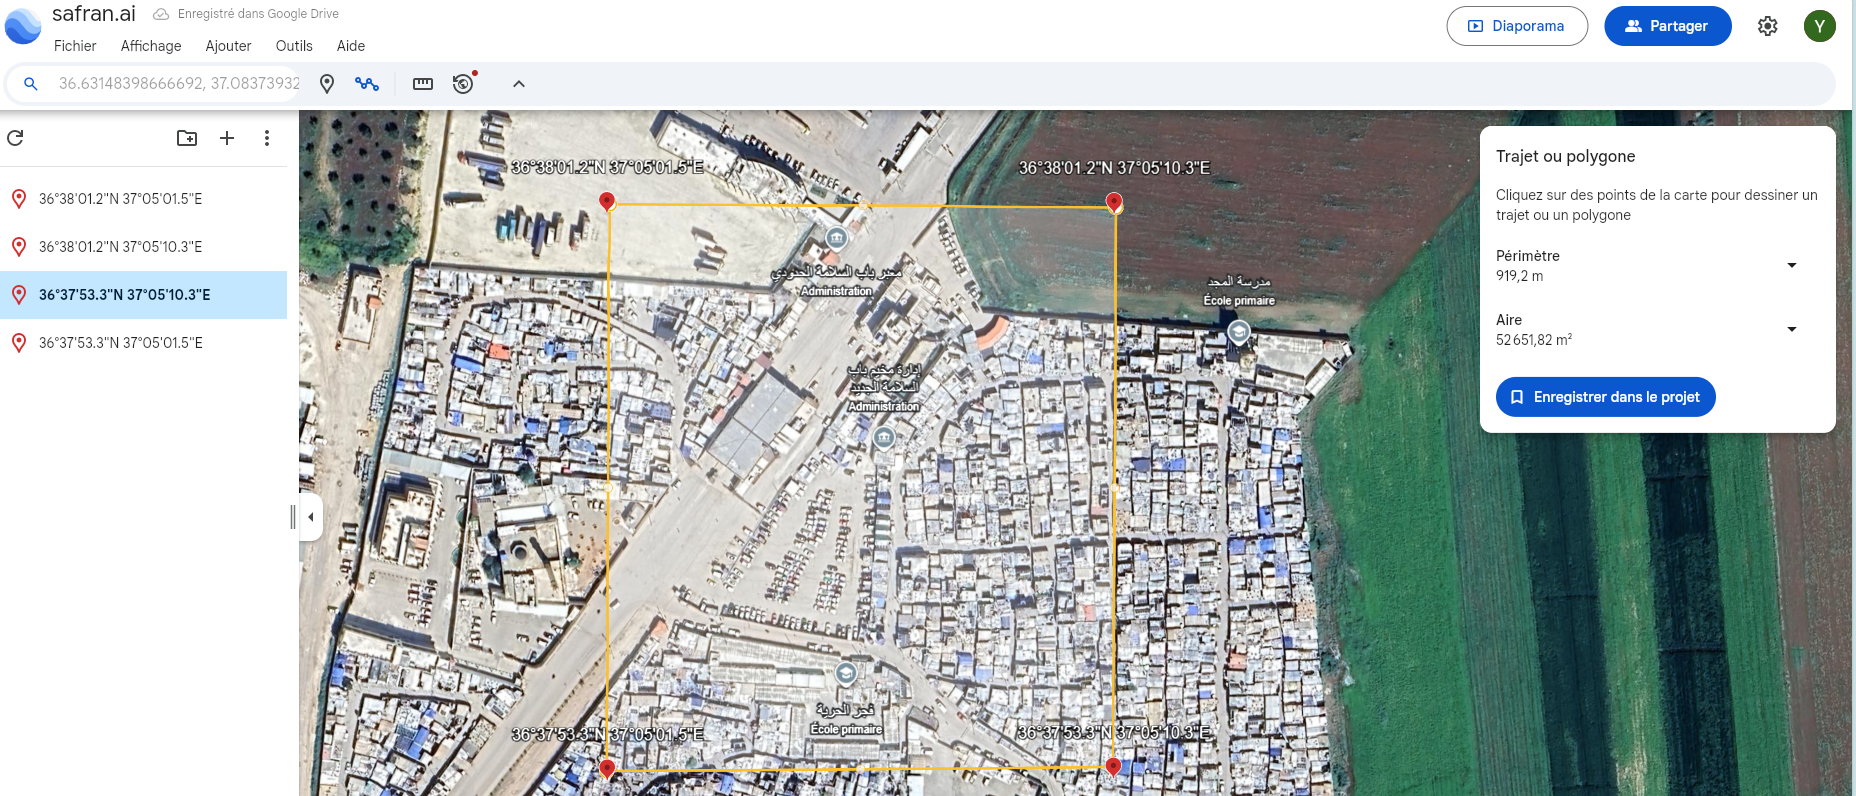

In [7]:
img = Image. open('Separation_Objets/thumbnails/google_earth_zone.PNG')
display(img)

Now let's process the shapes in order to get normalized coordinates in meters 

In [8]:
from src.utils.converter import project_and_normalize_shapes

In [9]:
shapes_normalized = project_and_normalize_shapes(shapes)

Next, we re create the image mask using the normalized for validation

In [10]:
from src.core.morphology import get_cv2_contours_from_shapes
from src.utils.display import draw_cc_from_contours

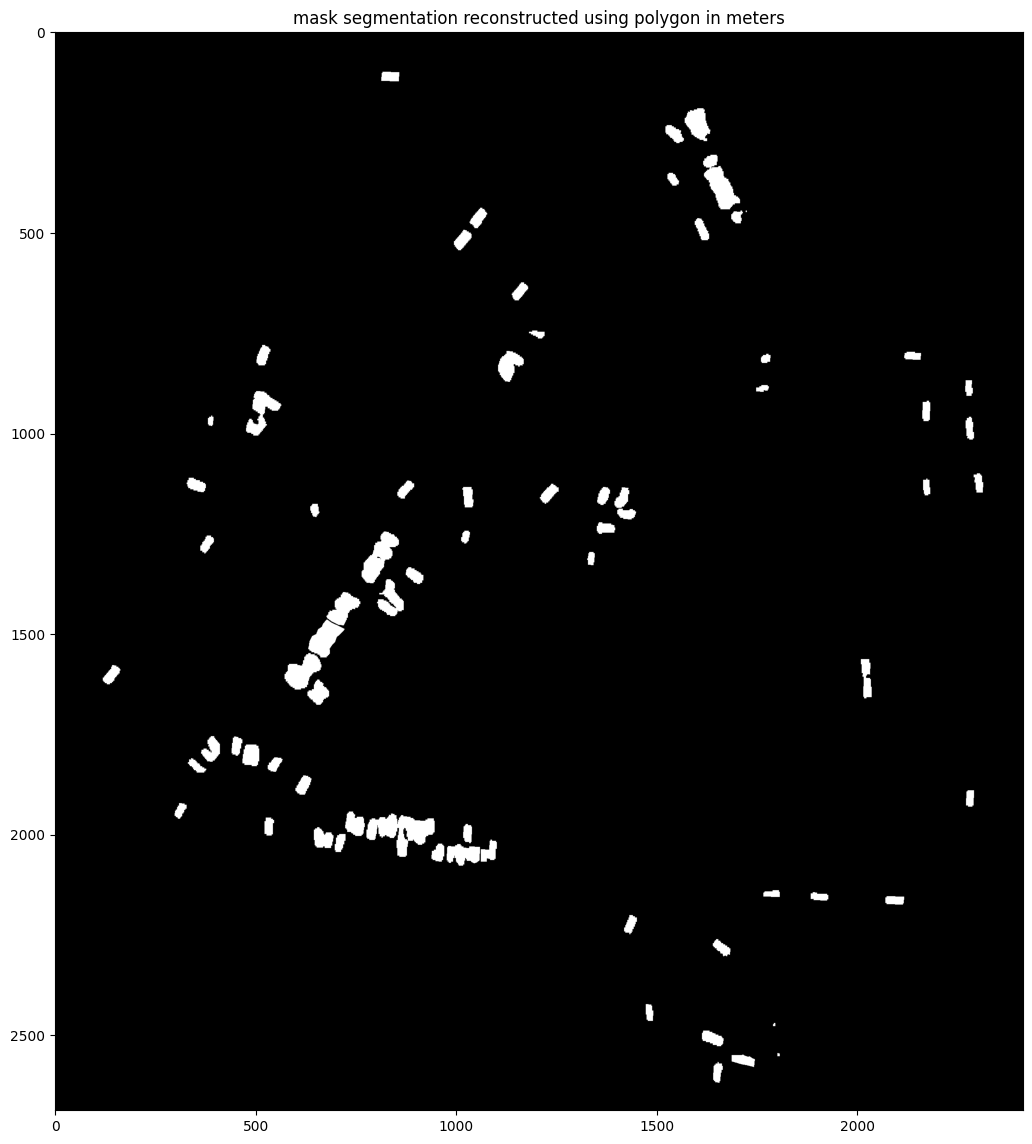

In [11]:
contours = get_cv2_contours_from_shapes(shapes_normalized)
draw_cc_from_contours(contours);

The idea now is to get a distribution of height, width of bounding boxes of connected components to identify a good clusters.

We expect to identify a cluster representing isolated vehicles

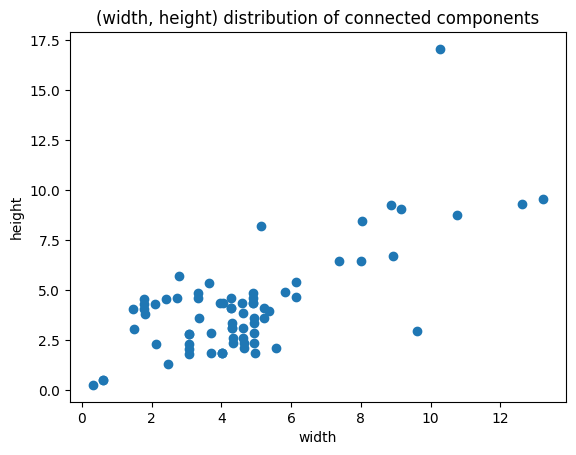

In [12]:
hv = [shape.bbox[2] - shape.bbox[0] for shape in shapes_normalized]
wv = [shape.bbox[3] - shape.bbox[1] for shape in shapes_normalized]
plt.scatter(wv,hv);
plt.xlabel("width")
plt.ylabel("height")
plt.title("(width, height) distribution of connected components")
plt.show()

As expected, there is a good insight here as we show that most point are centered around (height=4m, width=3m). But there is a room for improvement as vehicule can be rotated making height, width vehicles not exacty equal to the bounding box width, height.

We propose to get better height, width vehicle by fitting the best rectangle using cv2.

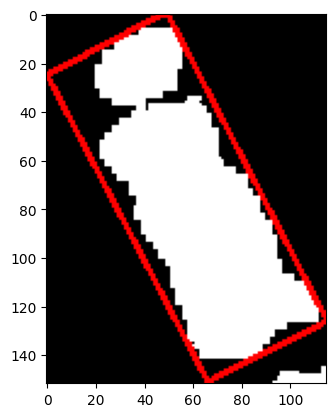

area: 59.73m²


In [47]:
from src.core.morphology import find_cc_best_enclosing_rectangles
find_cc_best_enclosing_rectangles(shapes_normalized, contours, index_display=4)

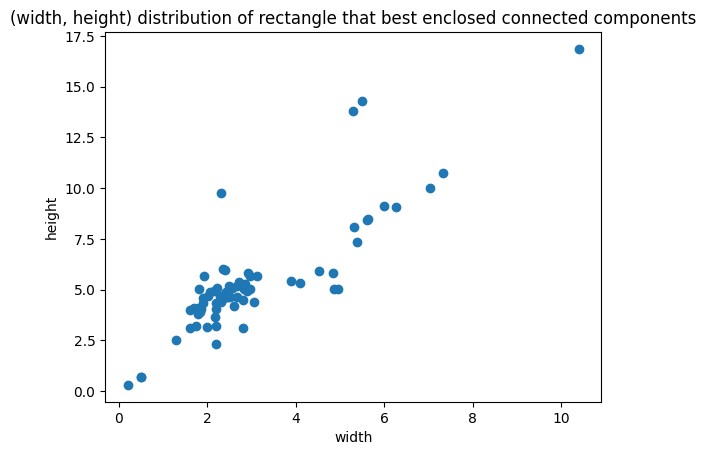

In [17]:
hv = [shape.rectangle_height for shape in shapes_normalized]
wv = [shape.rectangle_width for shape in shapes_normalized]
plt.scatter(wv,hv);
plt.xlabel("width")
plt.ylabel("height")
plt.title("(width, height) distribution of rectangle that best enclosed connected components")
plt.show()

As expected, we finally get a more compact cluster showing that there is a simple pattern to separate well isolated vehicule to other connected components

Now let's now get a Gaussian that fit that 2D (height, width) distribution

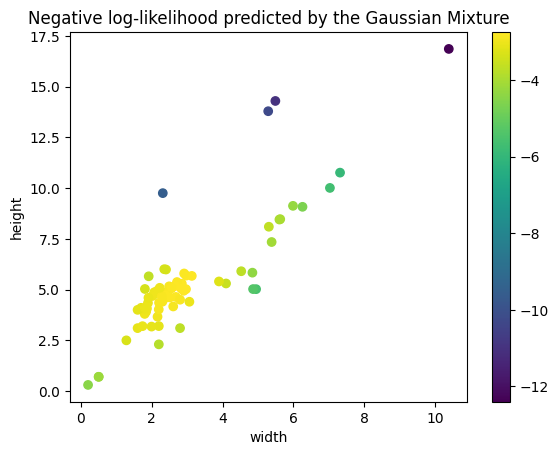

In [18]:
import numpy as np
import sklearn

gm = sklearn.mixture.GaussianMixture(n_components=1) # we use a mixture of gaussians model with only one component
X = np.concatenate((np.array(wv)[:,np.newaxis],np.array(hv)[:,np.newaxis]), axis=1)
gm.fit(X)
scorev = gm.score_samples(X)

sc = plt.scatter(wv, hv, c=scorev)
plt.colorbar(sc)
plt.title("Negative log-likelihood predicted by the Gaussian Mixture")
plt.axis("tight")
plt.xlabel("width")
plt.ylabel("height")
plt.show()

In [19]:
gm = sklearn.mixture.GaussianMixture(n_components=1, max_iter=500, covariance_type="diag", tol=1e-6, n_init=10, init_params='random') # we use a mixture of gaussians model with only one component
X = np.concatenate((np.array(wv)[:,np.newaxis],np.array(hv)[:,np.newaxis]), axis=1)
gm.fit(X)
scorev = gm.score_samples(X)

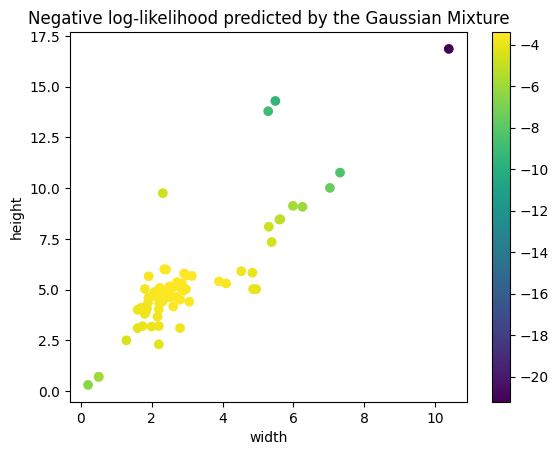

In [20]:
sc = plt.scatter(wv, hv, c=scorev)
plt.colorbar(sc)
plt.title("Negative log-likelihood predicted by the Gaussian Mixture")
plt.axis("tight")
plt.xlabel("width")
plt.ylabel("height")
plt.show()

In [21]:
print(gm.means_)

[[3.02695946 5.42500136]]


From here, we can use the Gaussian Mixture model and apply a threshold `thresh` on Negative log-likelihood score to get
- connected components with log-likelihood above `thresh`, meaning the connected component is a well single segmented vehicle
- connected components with likelihood under `thresh` meaning the connected component is one of the two outliers subcategories
    - single but not well segmented vehicle or a false alarm
    - many vehicles merged into one segment

The two outliers subcategories can then be separated by a comparing `height x weight` product to compare with the Gaussian mean.

Let's apply the following function that apply the process from gaussian fitting to the two outliers subcategories

In [27]:
from src.core.morphology import find_cc_outliers
mean_size, contours_good_category, contours_outliers_subcategory1, contours_outliers_subcategory2, index_good_category, index_outliers_subcategory1, index_outliers_subcategory2  = find_cc_outliers(shapes_normalized, contours, thresh=-3.1, plot=True)

In [28]:
len(contours_good_category)

(41, 41)

In [29]:
len(contours_outliers_subcategory1)

(14, 14)

In [30]:
len(contours_outliers_subcategory2)

(18, 18)

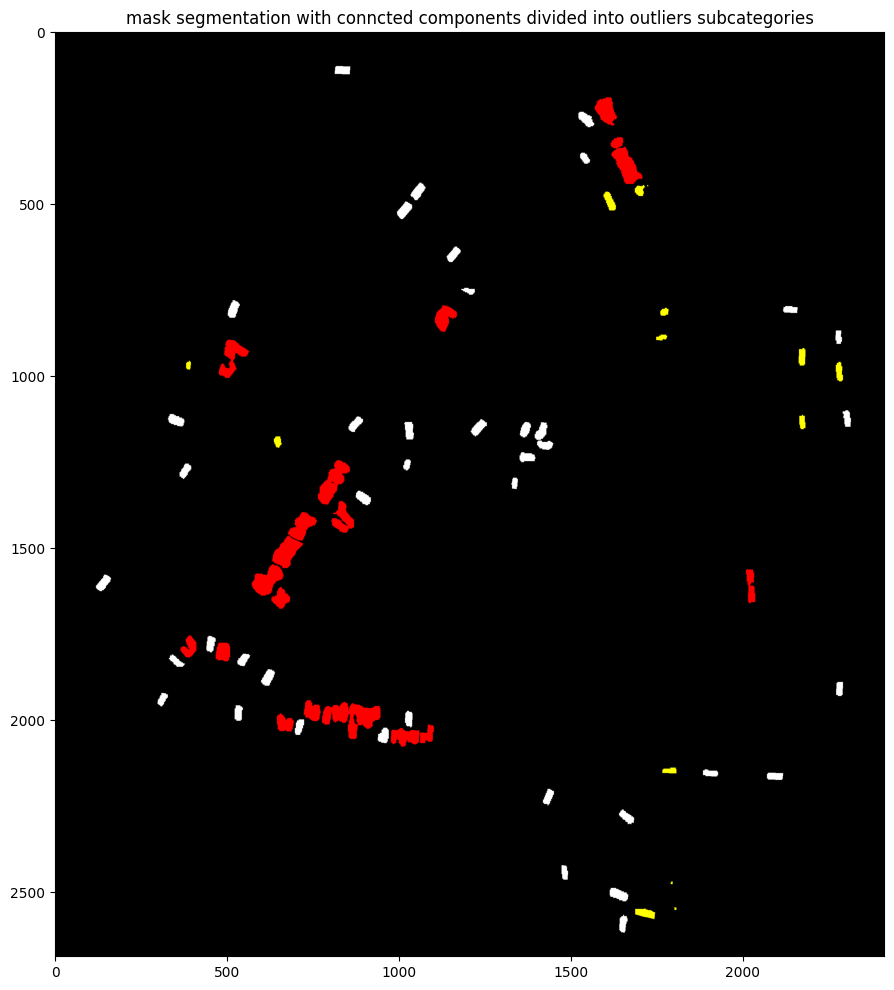

In [31]:
from src.utils.display import draw_cc_categories_from_contours

In [44]:
merged_vehicles_recounting = 0
for cc_index in index_outliers_subcategory2:
    recounting = round(shapes_normalized[cc_index].vehicles_area/mean_size)
    merged_vehicles_recounting += recounting
print(merged_vehicles_recounting)

42


In [43]:
merged_vehicles_recounting

42